# Base models

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

from scipy.special import logit, expit

## Logit-Normal
We use [logit-normal distribution Wikipedia page](https://en.wikipedia.org/wiki/Logit-normal_distribution) as prior and variational posterior distribution of Psi (Percent Spliced-in).

In practicce, we use $\mu=0, \sigma=3.0$ as prior, where the large variance is used to account for mono-isoform in most case.

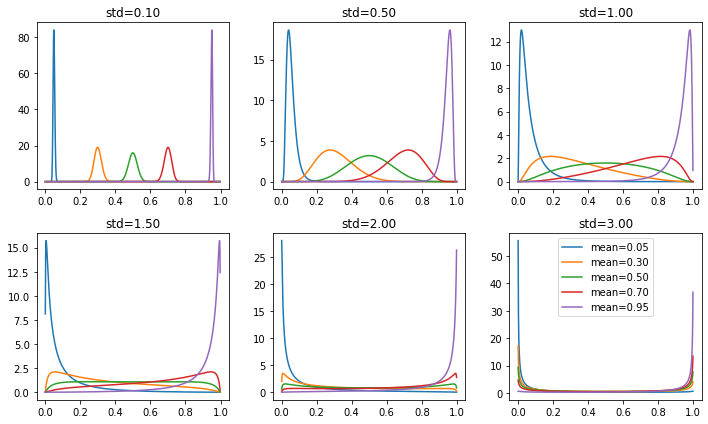

In [2]:
_means = np.array([0.05, 0.3, 0.5, 0.7, 0.95], dtype=np.float32)
_vars = np.array([0.1, 0.5, 1.0, 1.5, 2.0, 3.0], dtype=np.float32)

xx = np.arange(0.001, 0.999, 0.001).astype(np.float32)

fig = plt.figure(figsize=(10, 6))
for j in range(len(_vars)):
    plt.subplot(2, 3, j + 1)
    for i in range(len(_means)):
        _raw_pdf = st.norm.pdf(logit(xx), logit(_means[i:i+1]), _vars[j:j+1])
        _pdf = _raw_pdf / (xx * (1 - xx))
        plt.plot(xx, _pdf, label="mean=%.2f" %(_means[i]))
    plt.title("std=%.2f" %(_vars[j]))
    if j == 5:
        plt.legend(loc="best")
        
plt.tight_layout()
plt.show()

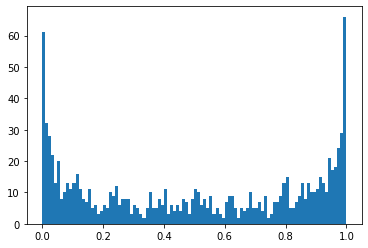

In [3]:
plt.hist(expit(st.norm.rvs(0, 3, 1000)), bins=100)
plt.show()

## Gamma distribution

The variance of the logit-normal distribution can be specified or assumed to follow a [Beta distribution Wikipedia page](https://en.wikipedia.org/wiki/Beta_distribution).

In practice, we use $\alpha=7, \beta=3$ as prior on the variance.

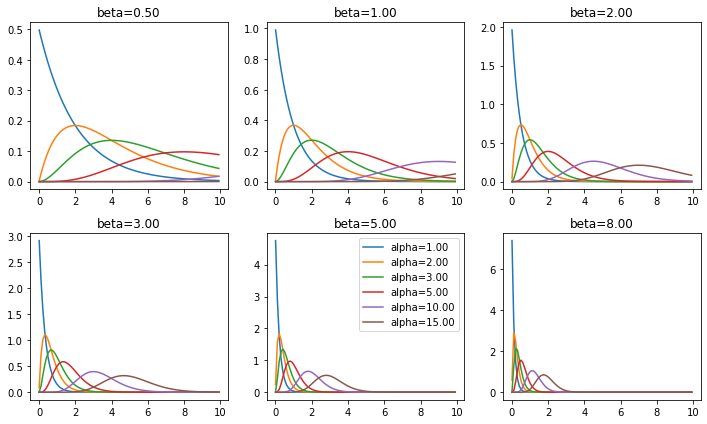

In [4]:
# _alpha = np.array([1, 2, 3, 5, 10, 15], dtype=np.float32)
# _beta = np.array([0.5, 1, 2, 3, 5, 8], dtype=np.float32)

_alpha = np.array([1, 2, 3, 5, 10, 15], dtype=np.float32)
_beta = np.array([0, 0.5, 1, 2, 3, 5, 8], dtype=np.float32)

# _beta = np.array([2, 3, 5, 10, 15], dtype=np.float32)
# _alpha = np.array([0.5, 1, 2, 3, 5, 8], dtype=np.float32)

xx = np.arange(0.01, 10, 0.1).astype(np.float32)

fig = plt.figure(figsize=(10, 6))
for j in range(1, len(_beta)):
    plt.subplot(2, 3, j)
    for i in range(len(_alpha)):
        _pdf = st.gamma.pdf(xx, a=_alpha[i:i+1], scale=1.0/_beta[j:j+1])
        plt.plot(xx, _pdf, label="alpha=%.2f" %(_alpha[i]))
    plt.title("beta=%.2f" %(_beta[j]))
    if j == 5:
        plt.legend(loc="best")
        
plt.tight_layout()
plt.show()

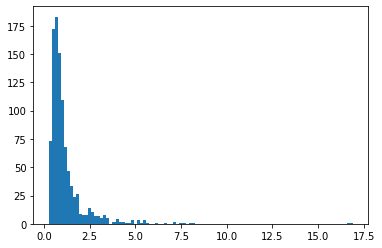

In [5]:
# plt.hist(1 / np.sqrt(st.gamma.rvs(a=3, scale=1.0/27, size=1000)), bins=100)
# plt.hist(1 / np.sqrt(st.gamma.rvs(a=2, scale=1.0/8, size=1000)), bins=100)

plt.hist(1 / np.sqrt(st.gamma.rvs(a=1, scale=1.0/0.5, size=1000)), bins=100)

# plt.hist(1 / np.sqrt(st.gamma.rvs(a=4, scale=1.0/1, size=1000)), bins=100)
# plt.hist(1 / np.sqrt(st.gamma.rvs(a=4.5, scale=1.0/0.5, size=1000)), bins=100)
plt.show()

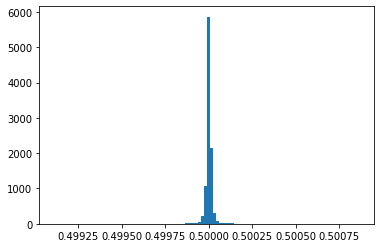

In [6]:
# _tau = 1 / np.sqrt(st.gamma.rvs(a=3, scale=1.0/27, size=100))
# _tau = 1 / np.sqrt(st.gamma.rvs(a=0.5, scale=1.0/1, size=100))
_tau = 1 / np.sqrt(st.gamma.rvs(a=1, scale=1000000000, size=100))

plt.hist(expit(st.norm.rvs(0, _tau, (100, 100)).reshape(-1)), bins=100)
plt.show()

In [7]:
_tau = 1 / np.sqrt(st.gamma.rvs(a=2, scale=1.0/1, size=100))

In [8]:
_tau.shape

(100,)

In [9]:
st.norm.rvs(0, _tau, (100, 100))

array([[ 0.87536916, -0.99628733, -0.11854584, ...,  1.65931877,
         0.12578313,  4.25609206],
       [-0.39713628,  0.2892034 , -0.0856904 , ...,  0.86375813,
        -0.85277462,  0.31648173],
       [-0.72522816, -1.03470371, -0.29727252, ...,  0.86623085,
         0.32571508, -0.20713939],
       ...,
       [-0.00660217,  0.26156419,  0.65496392, ...,  0.45374392,
         0.03478988, -2.9951383 ],
       [ 0.60541856,  0.13887404, -0.0211421 , ..., -1.10424389,
        -0.28029257,  1.02918013],
       [-1.02293858, -0.7197091 ,  1.49735114, ...,  0.93521689,
        -0.19092165,  2.50734252]])

### BRIE base likelihood

$$\mathcal{L}(\psi; L_1, L_2, L_3, S_1, S_2, S_3)=\mathtt{Multinom}([S_1, S_2, S_3]; [p_1, p_2, p_3])$$

$$[p_1, p_2, p_3] = [\psi L_1, (1-\psi)L_2, L_3] / (\psi L_1 + (1-\psi)L_2 + L_3)$$

In [10]:
from scipy.stats import multinomial

def BRIE_base_lik(psi, counts, lengths):
    """Base likelihood function of BRIE model
    """
    size_vect = np.array([psi, (1 - psi), 1]) * lengths
    prob_vect = size_vect / np.sum(size_vect)
    
    rv = multinomial(np.sum(counts), prob_vect)
    return rv.pmf(counts)

/home/yuanhua/.conda/envs/TFProb/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/home/yuanhua/.conda/envs/TFProb/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/home/yuanhua/.conda/envs/TFProb/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/home/yuanhua/.conda/envs/TFProb/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/home/yu

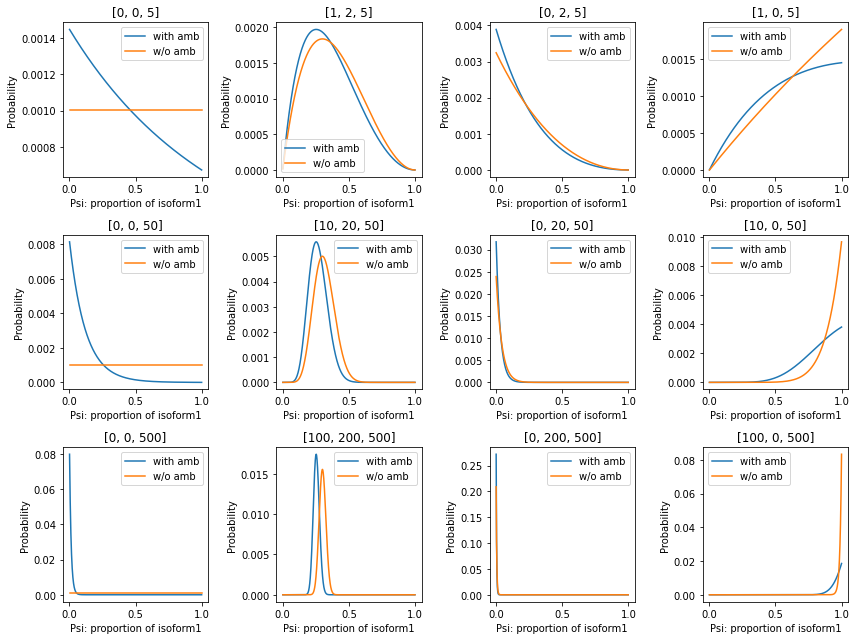

In [11]:
counts = [10, 20, 50]
lengths = [200, 100, 500]

count_list = [
    [0, 0, 5],
    [1, 2, 5],
    [0, 2, 5],
    [1, 0, 5],
    [0, 0, 50],
    [10, 20, 50],
    [0, 20, 50],
    [10, 0, 50],
    [0, 0, 500],
    [100, 200, 500],
    [0, 200, 500],
    [100, 0, 500]
]

fig = plt.figure(figsize=(12, 9))
for i in range(len(count_list)):
    counts = count_list[i]
    counts_no_amb = counts.copy()
    counts_no_amb[2] = 0

    xx = np.linspace(0, 1, 1001)[1:-1]
    yy = [BRIE_base_lik(x, counts, lengths) for x in xx]
    zz = [BRIE_base_lik(x, counts_no_amb, lengths) for x in xx]
    zz = zz / np.sum(zz)
    if sum(counts_no_amb) == 0:
        zz[:] = 1 / len(zz)
    yy = yy / np.sum(yy)

    plt.subplot(3, len(count_list) / 3, i+1)
    plt.plot(xx, yy, label="with amb")
    plt.plot(xx, zz, label="w/o amb")
    plt.title(counts)
    plt.xlabel("Psi: proportion of isoform1")
    plt.ylabel("Probability")
    plt.legend(loc='best')
    
plt.tight_layout()
plt.show()

/home/yuanhua/.conda/envs/TFProb/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/home/yuanhua/.conda/envs/TFProb/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/home/yuanhua/.conda/envs/TFProb/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/home/yuanhua/.conda/envs/TFProb/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/home/yu

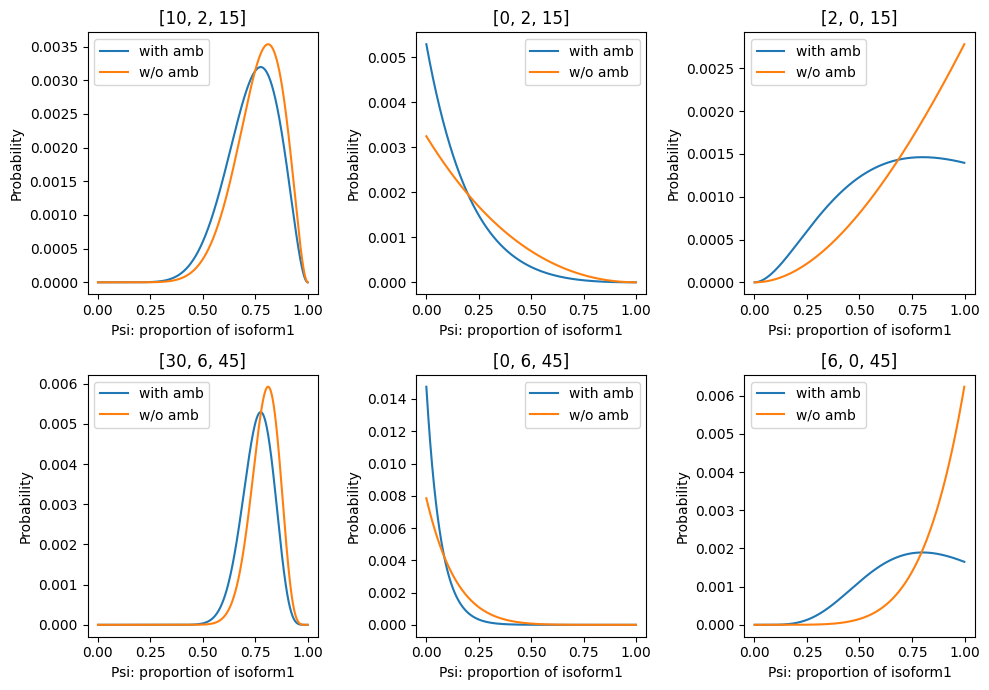

In [12]:
lengths = [200, 100, 500]

count_list = [
    [10, 2, 15],
    [0, 2, 15],
    [2, 0, 15],
    
    [30, 6, 45],
    [0, 6, 45],
    [6, 0, 45],
]

fig = plt.figure(figsize=(10, 7), dpi=100)
for i in range(len(count_list)):
    counts = count_list[i]
    counts_no_amb = counts.copy()
    counts_no_amb[2] = 0

    xx = np.linspace(0, 1, 1001)[1:-1]
    yy = [BRIE_base_lik(x, counts, lengths) for x in xx]
    zz = [BRIE_base_lik(x, counts_no_amb, lengths) for x in xx]
    zz = zz / np.sum(zz)
    if sum(counts_no_amb) == 0:
        zz[:] = 1 / len(zz)
    yy = yy / np.sum(yy)

    plt.subplot(2, len(count_list)/2, i+1)
    plt.plot(xx, yy, label="with amb")
    plt.plot(xx, zz, label="w/o amb")
    plt.title(counts) #['c1', 'c2', 'c3'], '=', 
    plt.xlabel("Psi: proportion of isoform1")
    plt.ylabel("Probability")
    plt.legend(loc='best')
    
plt.tight_layout()
plt.show()